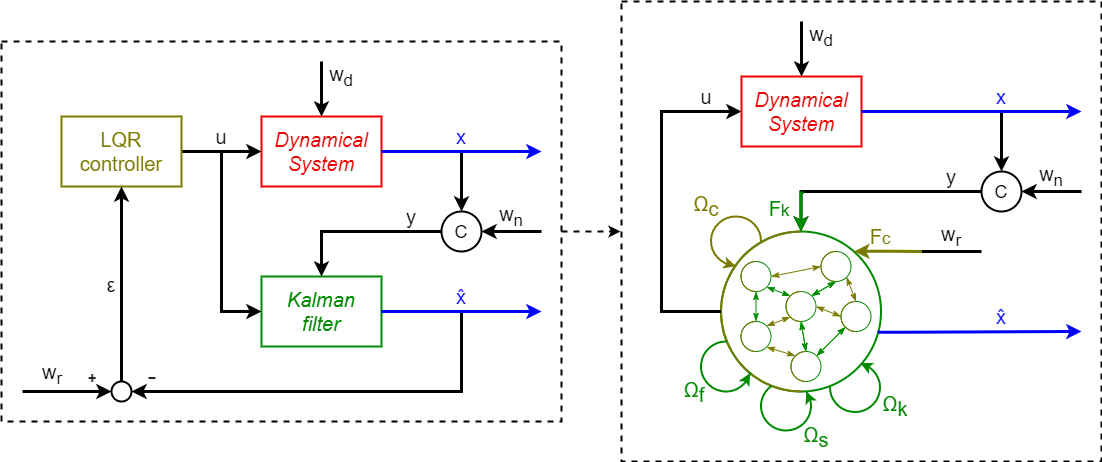

In [235]:
import numpy as np
import matplotlib.pyplot as plt
#import scipy.linalg
import control
import numba as nb
from tqdm.notebook import trange,tqdm
from joblib import Parallel, delayed
np.random.seed(0)

In [236]:
# @nb.jit(nopython=True)
# def run_network_step(y,x_des,Dx,r,s,v,D,T,lam,Kc,O_f,O_s,O_c,F_c,O_k,F_k,B,C,t,dt,sigma):
#     u_next = -Kc @ (D[:-2] @ r - D[2:] @ r)

#     # Calculating the voltages at time t+1
#     dvdt = -lam * v - O_f @ s + O_s @ r + (O_c @ r + F_c @ D[2:] @ r) - (O_k @ r + np.dot(F_k,C[0]*y))
#     dvdt = dvdt + (D[2:].T @ ((lam*x_des)+Dx)) - (D[2:].T @ D[2:] @ s)
#     v_next = v + dvdt*dt + np.sqrt(dt)*sigma*np.random.randn(len(dvdt))

#     # check if there are neurons whose voltage is above threshold
#     above = np.where(v_next > T)[0]

#     # introduce a control to let only one neuron fire at the time
#     s_next=np.zeros(s.shape)
#     if len(above):
#         s_next[np.argmax(v_next)] = 1/dt

#     # update rate
#     drdt = s_next - lam*r
#     r_next = r + drdt*dt
    
#     return r_next, s_next, v_next, u_next

In [237]:
# @nb.jit(nopython=True)
# def run_kalman_filter_step(x_hat,A,B,u,Kf,y,C,dt):
#     dxdt = A@x_hat + B@u + Kf@(y-(C[0]*x_hat))
#     x_next = x_hat + dxdt*dt
    
#     return x_next

In [238]:
# @nb.jit(nopython=True)
# def run_real_step(x,u,dist,m,M,L,g,d,dt):
#     Sy=np.sin(x[2])
#     Cy=np.cos(x[2])

#     D = m*L*L*(M+m*(1-Cy**2))
    
#     dy_1 = x[1] + dist[0]
#     dy_2 = (1/D)*(-m**2*L**2*g*Cy*Sy + m*L**2*(m*L*x[3]**2*Sy - d*x[1])) + m*L*L*(1/D)*u + dist[1]
#     dy_3 = x[3] + dist[2]
#     dy_4 = (1/D)*((m+M)*m*g*L*Sy - m*L*Cy*(m*L*x[3]**2*Sy - d*x[1])) - m*L*Cy*(1/D)*u + dist[3] #+0*np.random.randn() 
    
#     dxdt=np.array([dy_1, dy_2, dy_3, dy_4])

#     x_next=x+dxdt*dt
    
#     return x_next

In [239]:
@nb.jit(nopython=True)
def run_loop(Nt,X,A,B,U,uDIST,dt,X_2,U_2,error,error_scn,error_ideal,Y,C,uNOISE,Y_2,r,s,V,x_des,Dx,D,T,lam,Kc,O_f,O_s,O_c,F_c,O_k,F_k,voltage_noise_sigma,Kf,X_hat_fe,pulse_strength):
    for t in range(Nt):
            #Real step, generate y
            if t in range(int(Nt/2)-25,int(Nt/2)+25):
                dxdt = A@X[:,t] + B@U[:,t] + pulse_strength + np.sqrt(dt)*uDIST[:,t]
            else:
                dxdt = A@X[:,t] + B@U[:,t] + np.sqrt(dt)*uDIST[:,t]
            X[:,t+1] = X[:,t] + dxdt*dt
            
            if t in range(int(Nt/2)-25,int(Nt/2)+25):
                dxdt = A@X_2[:,t] + B@U_2[:,t] + pulse_strength + np.sqrt(dt)*uDIST[:,t]
            else:
                dxdt = A@X_2[:,t] + B@U_2[:,t] + np.sqrt(dt)*uDIST[:,t]
            X_2[:,t+1] = X_2[:,t] + dxdt*dt
            
#             if t == int(Nt/2):
#                 X[:,t+1] = X[:,t] + dxdt*dt + pulse_strength
#             else:
#                 X[:,t+1] = X[:,t] + dxdt*dt
            
#             dxdt = A@X_2[:,t] + B@U_2[:,t] + np.sqrt(dt)*uDIST[:,t]
#             if t == int(Nt/2):
#                 X_2[:,t+1] = X_2[:,t] + dxdt*dt + pulse_strength
#             else:
#                 X_2[:,t+1] = X_2[:,t] + dxdt*dt

            #print(C@X[:,t+1] + uNOISE[:,t])

            error[:,t+1] = np.abs(X[:,t+1]-X_2[:,t+1])
            
            error_scn[:,t+1] = np.abs(X[:,t+1]-x_des[:,t+1])
            error_ideal[:,t+1] = np.abs(X_2[:,t+1]-x_des[:,t+1])

            Y[:,t+1] = C[0]*X[:,t+1] + uNOISE[:,t+1]
            Y_2[:,t+1] = C[0]*X_2[:,t+1] + uNOISE[:,t+1]
            #print(Y[:,t+1]) #SENSOR NOISE ON SENSORS WE DON'T USE???

            #Network step, generate x_hat
            #r[:,t+1],s[:,t+1],V[:,t+1],U[:,t+1] = run_network_step(Y[:,t],x_des[:,t],Dx[:,t],r[:,t],s[:,t],V[:,t],D,T,lam,Kc,O_f,O_s,O_c,F_c,O_k,F_k,B,C,t,dt,voltage_noise_sigma)
            
            #if t == int(Nt/2):
            U[:,t+1] = -Kc @ (D[:-2] @ r[:,t] - D[2:] @ r[:,t])

            # Calculating the voltages at time t+1
            dvdt = -lam * V[:,t] - O_f @ s[:,t] + O_s @ r[:,t] + (O_c @ r[:,t] + F_c @ D[2:] @ r[:,t]) - (O_k @ r[:,t] + np.dot(F_k,C[0]*Y[:,t]))
            dvdt = dvdt + (D[2:].T @ ((lam*x_des[:,t])+Dx[:,t])) - (D[2:].T @ D[2:] @ s[:,t])
            V[:,t+1] = V[:,t] + dvdt*dt + np.sqrt(dt)*voltage_noise_sigma*np.random.randn(len(dvdt))

            # check if there are neurons whose voltage is above threshold
            above = np.where(V[:,t+1] > T)[0]

            # introduce a control to let only one neuron fire at the time
            s[:,t+1]=np.zeros(s[:,t].shape)
            if len(above):
                s[:,t+1][np.argmax(V[:,t+1])] = 1/dt

            # update rate
            drdt = s[:,t+1] - lam*r[:,t]
            r[:,t+1] = r[:,t] + drdt*dt
            
            #_______________________
            #X_hat[:,t+1] = D@r[:,t+1]
            dxdt = A@X_hat_fe[:,t] + B@U_2[:,t] + Kf@(Y_2[:,t]-(C[0]*X_hat_fe[:,t]))
            X_hat_fe[:,t+1] = X_hat_fe[:,t] + dxdt*dt
            
            #X_hat_fe[:,t+1] = run_kalman_filter_step(X_hat_fe[:,t],A,B,U_2[:,t],Kf,Y_2[:,t],C,dt)
            #if t == int(Nt/2):
            U_2[:,t+1] = -Kc@(X_hat_fe[:,t+1]-x_des[:,t])
    return D,r,s,V,T,X,X_2,error,error_scn,error_ideal,U,U_2,Y

In [240]:
# @nb.jit(nopython=True)
# def run_loop(Nt,X,A,B,U,uDIST,dt,X_2,U_2,error,Y,C,uNOISE,Y_2,r,s,V,x_des,Dx,D,T,lam,Kc,O_f,O_s,O_c,F_c,O_k,F_k,voltage_noise_sigma,Kf,X_hat_fe):
#     for t in range(Nt):
#     # compute inputs
#         c_x = (x[:, t] -
#                      x[:, t-1]) / dt + leak * x[:, t-1]

#         # update membrane potential
#         V[:, t] = V[:, t-1] + dt * (-leak * V[:, t-1] + D.T @ c_x) - Omeg @ s[:, t-1]
#         V[:, t] += np.sqrt(2 * dt * leak) * sigma_v * np.random.randn(N)

#         # update filtered spiketrains
#         r[:, t] = (1 - leak * dt) * r[:, t-1] + s[:, t-1]

#         # Check if any neurons are past their threshold during the last time-step
#         VminT = V[:, t] - T
#         spiking_indices = np.arange(N)[VminT >= 0]
#         if spiking_indices.size > 0:
#             # Pick the neuron which likely would have spiked first, by max distance from threshold
#             to_pick = np.argmax(VminT[spiking_indices])
#             spike_index = spiking_indices[to_pick]

#             # Update membrane potential
#             s[spike_index, t] = 1
#     return D,r,s,V,T,X,X_2,error

In [241]:
def run_kf_pipeline(A,B,Kc,x0,x_des,Vd,Vn,Kf,dt,Nt,voltage_noise_sigma,network_size,signal_dimensions,lam,pulse_strength,control_on=True):
    #Pipeline

    #Initialization of 'real system'
    X=np.zeros([len(x0),Nt+1])
    X[:,0]=x0
    
    #Initialization of 'real system 2'
    X_2=np.zeros([len(x0),Nt+1])
    X_2[:,0]=x0
    
    error=np.zeros([len(x0),Nt+1])
    error_ideal=np.zeros([len(x0),Nt+1])
    error_scn=np.zeros([len(x0),Nt+1])

    #First, initialize the network
    N = network_size #network size
    K = signal_dimensions #signal dimensions
    D=np.random.randn(K,N) # N x K - Weights associated to each neuron
    D=D/np.linalg.norm(D,axis=0) #normalize
    D = D / 10 # avoid too big discontinuities
    T = np.diag(D.T@D)/2
    # Initialize Voltage, spikes, rate
    V = np.zeros([N,Nt+1])
    s = np.zeros([N,Nt+1])
    r = np.zeros([N,Nt+1])
    # Set initial conditions
    #r[:,0] = np.array(np.linalg.pinv(D)@x0) # pseudo-inverse - "cheaty" way of getting the right firing rate
    #V[:,0] = D.T@(x0-D@r[:,0])
    # Network connections:
    # - fast
    O_f = D[:-2].T @ D[:-2]
    # - slow
    O_s = D[:-2].T @ (lam*np.identity(K-2) + A) @ D[:-2]
    # - rec. control
    O_c = -D[:-2].T @ B @ Kc @ D[:-2]
    # - ff. control
    F_c = D[:-2].T @ B @ Kc
    # - rec. kalman
    O_k = D[:-2].T @ Kf @ C @ D[:-2]
    # - ff kalman
    F_k = -D[:-2].T @ Kf

    #Initialization for loop
    U = np.zeros([B.shape[1],Nt+1])
    Y = np.zeros([C.shape[0],Nt+1])
    #Y = np.zeros([C.shape[1],Nt+1])
    X_hat = np.zeros([len(x0),Nt+1])
    X_hat_fe = np.zeros([len(x0),Nt+1])
    #X_hat_fe[:,0]=x0
    U_correct = np.zeros([B.shape[1],Nt+1])
    
    #Initialization for loop
    U_2 = np.zeros([B.shape[1],Nt+1])
    Y_2 = np.zeros([C.shape[0],Nt+1])
    #Y = np.zeros([C.shape[1],Nt+1])


    #U[:,1000:1200] = 100
    #U[:,15000:15200] = -100

    #uDIST = Vd@Vd@np.random.randn(4,Nt+1);
    #print(uDIST)
    #uNOISE = Vn@Vn@np.random.randn(4,Nt+1);
    #print(uNOISE.shape)
    uDIST = np.random.multivariate_normal([0,0],Vd,Nt+1).T;
    #print(uDIST)
    uNOISE = np.random.multivariate_normal([0,0],Vn,Nt+1).T;
    #print(uNOISE.shape)

    Y[:,0] = C@X[:,0] + np.sqrt(dt)*uNOISE[:,0]
    
    Y_2[:,0] = C@X_2[:,0] + np.sqrt(dt)*uNOISE[:,0]
    
    Dx=np.gradient(x_des,axis=1)/dt
    
    error_scn[:,0] = np.abs(X[:,0]-x_des[:,0])
    error_ideal[:,0] = np.abs(X_2[:,0]-x_des[:,0])

    #Loop
    return run_loop(Nt,X,A,B,U,uDIST,dt,X_2,U_2,error,error_scn,error_ideal,Y,C,uNOISE,Y_2,r,s,V,x_des,Dx,D,T,lam,Kc,O_f,O_s,O_c,F_c,O_k,F_k,voltage_noise_sigma,Kf,X_hat_fe,pulse_strength)

In [242]:
# # common parameters
# Time = 5 # total time, seconds
# dt = 0.0001 # time step
# times = np.arange(0, Time, dt)
# Nt=len(times)

# #Parameters
# m=20 #mass (in kg)
# k=6 #spring constant (in N/m)
# c=2 #constant of proportionality (in Ns/m = kg/s)

# voltage_noise_sigma = 0.00001

# #s = 1; #s=1 for pendulum up. s=-1 for pendulum down

# # Setup connectivity for dynamics:
# A = np.array([[0,1],
#               [(-k/m),(-c/m)]]) # A-matrix, defines dynamics of the DS.

# B = np.array([[0],[1/m]]) # B-matrix, defines the influence of the force on the system.
# x0 = np.array([5, 0]) # Initial state of the system.

# # Check controllability 
# print("Rank of controllability-matrix:", np.linalg.matrix_rank(control.ctrb(A,B)))

# # Control-parameters
# Q = np.array([[10,0],[0,1]])
# R = 0.001
# Kc,_,_ = control.lqr(A,B,Q,R)

# # Desired states
# x0_des = np.full([Nt+1],0) # Desired x0, position.
# x1_des = np.full([Nt+1],0) # Desired x1, velocity.

# # # Change desired state over time
# # x0_des[int(Nt/5):int(Nt/5)*2] = 5
# # x0_des[int(Nt/5)*2:int(Nt/5)*3] = 10
# # x0_des[int(Nt/5)*3:int(Nt/5)*4] = 15
# # x0_des[int(Nt/5)*4:] = 20

# x_des = np.array([x0_des,x1_des]) # Desired states over time.
# x0_des = np.concatenate((x0, x_des[:,0]))

# #Covariance matrices
# Vd = 10*np.identity(2)  # disturbance covariance
# Vn = 10*np.identity(2)     # noise covariance

# #Kalman filter & C-matrix
# C=np.array([[1,0],
#             [0,0]])
# #C=np.array([1,0])
# #Kf,_,_=control.lqe(A,Vd,C,Vd,Vn)
# #Kf,_,_=np.transpose(control.lqr(np.transpose(A),np.transpose(np.reshape(C,(1,4))),Vd,Vn))
# Kf_t,_,_=control.lqr(np.transpose(A),np.transpose(C),Vd,Vn)
# Kf=np.transpose(Kf_t)

In [243]:
def run_with_params(sensornoise,pulse_strength):
# common parameters
    print("Run starting...")
    Time = 5 # total time, seconds
    dt = 0.0001 # time step
    times = np.arange(0, Time, dt)
    Nt=len(times)

    #Parameters
    m=3 #mass (in kg)
    k=5 #spring constant (in N/m)
    c=0.5 #constant of proportionality (in Ns/m = kg/s)

    voltage_noise_sigma = 0.000001

    #s = 1; #s=1 for pendulum up. s=-1 for pendulum down

    # Setup connectivity for dynamics:
    A = np.array([[0,1],
                  [(-k/m),(-c/m)]]) # A-matrix, defines dynamics of the DS.

    B = np.array([[0],[1/m]]) # B-matrix, defines the influence of the force on the system.
    x0 = np.array([0, 0]) # Initial state of the system.

    # Check controllability 
    #print("Rank of controllability-matrix:", np.linalg.matrix_rank(control.ctrb(A,B)))

    # Control-parameters
    Q = np.array([[10,0],[0,1]])
    R = 0.001
    Kc,_,_ = control.lqr(A,B,Q,R)

    # Desired states
    x0_des = np.full([Nt+1],0) # Desired x0, position.
    x1_des = np.full([Nt+1],0) # Desired x1, velocity.

    # Change desired state over time
#     x0_des[int(Nt/5):int(Nt/5)*2] = 5
#     x0_des[int(Nt/5)*2:int(Nt/5)*3] = 10
#     x0_des[int(Nt/5)*3:int(Nt/5)*4] = 15
#     x0_des[int(Nt/5)*4:] = 20

    x_des = np.array([x0_des,x1_des]) # Desired states over time.
    x0_des = np.concatenate((x0, x_des[:,0]))

    #Covariance matrices
    Vd = 0.001*np.identity(2)  # disturbance covariance
    Vn = sensornoise*np.identity(2)     # noise covariance

    #Kalman filter & C-matrix
    C=np.array([[1,0],
               [0,0]])
    #Kf,_,_=control.lqe(A,Vd,C,Vd,Vn)
    #Kf,_,_=np.transpose(control.lqr(np.transpose(A),np.transpose(np.reshape(C,(1,4))),Vd,Vn))
    Kf_t,_,_=control.lqr(np.transpose(A),np.transpose(C),Vd,Vn)
    Kf=np.transpose(Kf_t)

    network_size=50
    signal_dimensions=4
    lam=0.1

    # Run the spike coding network with previously defined parameters:
    D,r,s,V,T,X_scn,X_fe,error,error_scn,error_ideal,U,U_2,Y = run_kf_pipeline(A,B,Kc,x0,x_des,Vd,Vn,Kf,dt,Nt,voltage_noise_sigma,network_size,signal_dimensions,lam,pulse_strength,control_on=True)
    #X_snn = D @ r # Decode the spike rates into DS states. 
    pulse_strength_list = np.zeros([B.shape[1],Nt+1])
    pulse_strength_list[:,int(Nt/2)-25:int(Nt/2)+25]=pulse_strength
    U_with_pulse=U+pulse_strength_list
    U_2_with_pulse=U_2+pulse_strength_list
    return np.average(error_scn,axis=1),np.average(error_ideal,axis=1),U,U_2,U_with_pulse,U_2_with_pulse,X_scn,X_fe,pulse_strength_list,x_des,Y

#Grid search
n_sensornoise = [1e-5,1e-4,1e-3,1e-2,1e-1]
n_pulse_strength = range(0,1000,100)
error_list = {}
for i,sensornoise in tqdm(enumerate(n_sensornoise),total=len(n_sensornoise)):
    error_list[i] = Parallel(n_jobs=-1)(delayed(run_with_params)(sensornoise, pulse_strength) for pulse_strength in n_pulse_strength)
#     for j, neurons in enumerate(n_neurons):
#         print(str(i*len(n_neurons)+j)+" of "+str(len(n_noise)*len(n_neurons)))
#         error_list[i*len(n_neurons)+j] = run_with_params(noise,neurons)

  0%|          | 0/5 [00:00<?, ?it/s]

In [244]:
for i,sensor in enumerate(n_sensornoise):
    for j, pulse_strength in enumerate(n_pulse_strength):
        #print(error_list[i][j][0][0])
        print(error_list[i][j][3][0][int(Nt/2)-15:int(Nt/2)+15])

[-0.00198035 -0.00221483 -0.00189439 -0.00196721 -0.00164787 -0.00077867
 -0.00101494 -0.00108711 -0.00172371 -0.00273466 -0.00300157 -0.00300005
 -0.00335345 -0.00363184 -0.00382608 -0.0037932  -0.00404326 -0.00397202
 -0.00455649 -0.00525181 -0.00511843 -0.00565003 -0.00579637 -0.00586291
 -0.00565661 -0.00643805 -0.0066663  -0.00644886 -0.0064933  -0.00632945]
[-0.0493498  -0.06196943 -0.07578134 -0.09038545 -0.1068645  -0.12474757
 -0.14389745 -0.16387326 -0.18566169 -0.20861932 -0.2327891  -0.25795655
 -0.28354091 -0.31150728 -0.34070682 -0.37075559 -0.40162315 -0.43385162
 -0.4683787  -0.50259061 -0.53857173 -0.57604954 -0.61411208 -0.65340316
 -0.69352816 -0.73522112 -0.7782177  -0.82303486 -0.86827062 -0.91541797]
[-0.12276679 -0.14815895 -0.17585136 -0.20623783 -0.23846705 -0.27328095
 -0.31116331 -0.35152001 -0.39471462 -0.4399597  -0.48717173 -0.5368585
 -0.58998068 -0.64474947 -0.70219047 -0.76201934 -0.82401393 -0.88879549
 -0.9562797  -1.02593576 -1.09789058 -1.1724041  -

In [245]:
error_list[0][5][6][0][int(Nt/2)-50:int(Nt/2)+50]

array([5.93941658e-06, 5.88988552e-06, 5.89680273e-06, 5.85557847e-06,
       5.86050151e-06, 5.85066276e-06, 5.88087499e-06, 5.89236036e-06,
       5.86465595e-06, 5.84680314e-06, 5.89921981e-06, 5.98605480e-06,
       6.00975871e-06, 5.99049586e-06, 5.92352397e-06, 5.95685726e-06,
       5.98878403e-06, 5.97065240e-06, 5.96835665e-06, 6.01564486e-06,
       5.91309736e-06, 5.91529296e-06, 5.87184583e-06, 5.84098598e-06,
       5.84686913e-06, 5.83515051e-06, 5.00058327e-02, 1.00010798e-01,
       1.50020763e-01, 2.00035701e-01, 2.50055645e-01, 3.00080618e-01,
       3.50110638e-01, 4.00145572e-01, 4.50185597e-01, 5.00230592e-01,
       5.50280577e-01, 6.00335606e-01, 6.50395584e-01, 7.00460593e-01,
       7.50530481e-01, 8.00605369e-01, 8.50685225e-01, 9.00770080e-01,
       9.50859954e-01, 1.00095479e+00, 1.05105458e+00, 1.10115943e+00,
       1.15126926e+00, 1.20138408e+00, 1.25150380e+00, 1.30162847e+00,
       1.35175817e+00, 1.40189281e+00, 1.45203248e+00, 1.50217711e+00,
      

<Figure size 864x576 with 0 Axes>

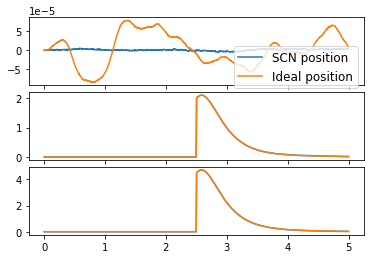

In [246]:
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(12)
legend_fontsize=12

fig, axs = plt.subplots(3,1, sharex=True, squeeze=True, gridspec_kw = {'hspace':0.1,'height_ratios':[1,1,1]})
#print(error_list[0][0][4])
legend=[]
axs[0].plot(np.arange(0,Time+dt,dt),error_list[0][0][6][0])
legend.append("SCN position")
axs[0].plot(np.arange(0,Time+dt,dt),error_list[0][0][7][0])
legend.append("Ideal position")
axs[1].plot(np.arange(0,Time+dt,dt),error_list[0][4][6][0])
axs[1].plot(np.arange(0,Time+dt,dt),error_list[0][4][7][0])
axs[2].plot(np.arange(0,Time+dt,dt),error_list[0][9][6][0])
axs[2].plot(np.arange(0,Time+dt,dt),error_list[0][9][7][0])
#axs[1].legend(legend,fontsize=legend_fontsize,loc='right')
fig.legend(legend,fontsize=legend_fontsize,loc='upper right',bbox_to_anchor=(0.90,0.8))
plt.show()

<Figure size 864x576 with 0 Axes>

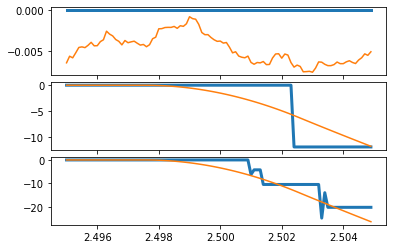

In [247]:
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(12)

fig, axs = plt.subplots(3,1, sharex=True, squeeze=True, gridspec_kw = {'hspace':0.1,'height_ratios':[1,1,1]})
#print(error_list[0][0][4])
axs[0].plot(np.arange(0,Time+dt,dt)[int(Nt/2)-50:int(Nt/2)+50],error_list[0][0][2][0][int(Nt/2)-50:int(Nt/2)+50],linewidth=3)
axs[0].plot(np.arange(0,Time+dt,dt)[int(Nt/2)-50:int(Nt/2)+50],error_list[0][0][3][0][int(Nt/2)-50:int(Nt/2)+50])
axs[1].plot(np.arange(0,Time+dt,dt)[int(Nt/2)-50:int(Nt/2)+50],error_list[0][4][2][0][int(Nt/2)-50:int(Nt/2)+50],linewidth=3)
axs[1].plot(np.arange(0,Time+dt,dt)[int(Nt/2)-50:int(Nt/2)+50],error_list[0][4][3][0][int(Nt/2)-50:int(Nt/2)+50])
axs[2].plot(np.arange(0,Time+dt,dt)[int(Nt/2)-50:int(Nt/2)+50],error_list[0][9][2][0][int(Nt/2)-50:int(Nt/2)+50],linewidth=3)
axs[2].plot(np.arange(0,Time+dt,dt)[int(Nt/2)-50:int(Nt/2)+50],error_list[0][9][3][0][int(Nt/2)-50:int(Nt/2)+50])
plt.show()

<Figure size 864x576 with 0 Axes>

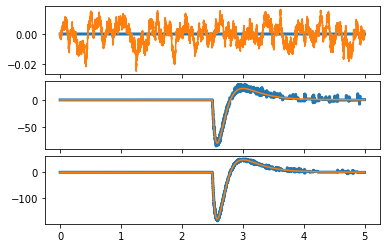

In [248]:
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(12)

fig, axs = plt.subplots(3,1, sharex=True, squeeze=True, gridspec_kw = {'hspace':0.1,'height_ratios':[1,1,1]})
#print(error_list[0][0][4])
axs[0].plot(np.arange(0,Time+dt,dt),error_list[0][0][2][0],linewidth=3)
axs[0].plot(np.arange(0,Time+dt,dt),error_list[0][0][3][0])
axs[1].plot(np.arange(0,Time+dt,dt),error_list[0][4][2][0],linewidth=3)
axs[1].plot(np.arange(0,Time+dt,dt),error_list[0][4][3][0])
axs[2].plot(np.arange(0,Time+dt,dt),error_list[0][9][2][0],linewidth=3)
axs[2].plot(np.arange(0,Time+dt,dt),error_list[0][9][3][0])
plt.show()

In [249]:
print(error_list)

{0: [(array([1.83921315e-06, 1.37548382e-06]), array([3.53439159e-05, 1.47872484e-04]), array([[0., 0., 0., ..., 0., 0., 0.]]), array([[0.00000000e+00, 4.48431016e-06, 2.87693128e-04, ...,
        2.23110290e-03, 1.99962698e-03, 1.67642766e-03]]), array([[0., 0., 0., ..., 0., 0., 0.]]), array([[0.00000000e+00, 4.48431016e-06, 2.87693128e-04, ...,
        2.23110290e-03, 1.99962698e-03, 1.67642766e-03]]), array([[ 0.00000000e+00, -1.54900419e-08, -6.85727497e-09, ...,
         2.63315951e-06,  2.69365713e-06,  2.68044649e-06],
       [ 0.00000000e+00, -1.43553796e-08, -8.49788817e-10, ...,
        -3.21383371e-06, -3.18905473e-06, -3.17928356e-06]]), array([[ 0.00000000e+00, -1.54900419e-08, -6.85727497e-09, ...,
         8.31863763e-06,  8.35511145e-06,  8.31788475e-06],
       [ 0.00000000e+00, -1.43553796e-08, -7.00311811e-10, ...,
        -2.43451848e-04, -2.43349642e-04, -2.43270158e-04]]), array([[0., 0., 0., ..., 0., 0., 0.]]), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ...

In [250]:
scn_avg_pos_error=[]
for i,sensor in enumerate(n_sensornoise):
    x_scn_ax=[]
    for j, pulse_strength in enumerate(n_pulse_strength):
        #print(error_list[i][j][0][0])
        x_scn_ax.append(error_list[i][j][0][0])
    scn_avg_pos_error.append(x_scn_ax)
print(scn_avg_pos_error)

ideal_avg_pos_error=[]
for i,sensor in enumerate(n_sensornoise):
    x_ideal_ax=[]
    for j, pulse_strength in enumerate(n_pulse_strength):
        #print(error_list[i][j][0][0])
        x_ideal_ax.append(error_list[i][j][1][0])
    ideal_avg_pos_error.append(x_ideal_ax)
print(ideal_avg_pos_error)

[[1.839213151327168e-06, 0.06106703371815339, 0.12337592066702378, 0.1824556380631331, 0.24389633741768244, 0.30245692843380656, 0.36305828331651896, 0.4258625248388314, 0.4866131371467022, 0.5451534499236663], [3.114812503529274e-06, 0.0846250299917396, 0.16704942363354516, 0.25469198660153786, 0.3362188526863411, 0.42083263892965306, 0.5050361555235251, 0.5881156788191895, 0.6710751708311259, 0.7553814713781845], [3.7407420807463027e-06, 0.1346533815516613, 0.2714000894072027, 0.40427228692393735, 0.5363688006144366, 0.6760006315153996, 0.8092151925626434, 0.9429607038519564, 1.0782636242167867, 1.2117855871461995], [3.5700943677272506e-06, 0.17596482034973102, 0.34918895056629934, 0.5214299649054045, 0.7008285236500311, 0.8755015015189399, 1.0513649922043065, 1.227090393534894, 1.3988067005096227, 1.5735953964142957], [1.4407560163017537e-06, 0.19245890694695442, 0.3844048797209163, 0.5758837679516106, 0.7596567895306203, 0.9513005270025611, 1.13197193614086, 1.3320956600121592, 1.5

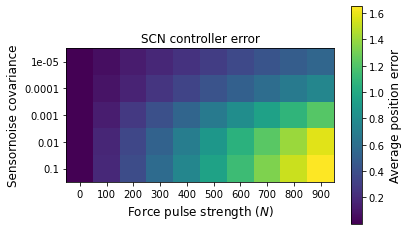

In [251]:
# Plot dynamical variables in seperate plots
from matplotlib.colors import LogNorm
from matplotlib.ticker import FuncFormatter

def scientific(x, pos):
    # x:  tick value - ie. what you currently see in yticks
    # pos: a position - ie. the index of the tick (from 0 to 9 in this example)
    if x == 0:
        return 0
    else:
        return str(x) + "e3"

scientific_formatter = FuncFormatter(scientific)

fig = plt.figure()
ax = plt.axes()
#fig.set_figheight(12)
#fig.set_figwidth(6)
#fig.set_figheight(4)
#fig.set_figwidth(12)
legend_fontsize=12

#ax1 = plt.subplot2grid(shape=(3, 1), loc=(0, 0), colspan=1)
#ax2 = plt.subplot2grid(shape=(3, 1), loc=(1, 0), colspan=1)
#ax3 = plt.subplot2grid(shape=(3, 1), loc=(0, 1), rowspan=2)

# Run the 'real' dynamical system with previously defined A-matrix and x0:
#_fe = X_hat_fe

#OLD HEX VALUES
#EE0000
#008A00
#D100D1

# "of position (x$_{1}$ and x̂$_{1}$) and acceleration (x$_{2}$ and x̂$_{2}$)"
legend=[]
plt.imshow(scn_avg_pos_error,vmax=1.65)
ax.set_xticks(range(len(n_pulse_strength)))
ax.set_xticklabels(n_pulse_strength)
#plt.ticklabel_format(style='scientific')
ax.set_yticks(range(len(n_sensornoise)))
ax.set_yticklabels(n_sensornoise)
#ax.xaxis.set_major_formatter(scientific_formatter)
ax.set_xlabel('Force pulse strength ($N$)',fontsize = 12)
ax.set_ylabel('Sensornoise covariance',fontsize = 12)

colorbar = plt.colorbar()
colorbar.ax.set_ylabel('Average position error', fontsize = 12)
# legend.append("x$^*_{"+str(1)+"}$")
# #ax1.plot(np.arange(0,Time+dt,dt),X_hat_fe[0],color='#0000FF')
# #legend.append("x̂$_{"+str(1)+"}$_FE")
# axs[0].plot(np.arange(0,Time+dt,dt),X_scn[0],color='#00B050')
# legend.append("x$_{"+str(1)+"}$")
# axs[0].plot(np.arange(0,Time+dt,dt),x_des[0],linestyle='dashed',c="#0070C0")
# legend.append("z$_{1}$")
# axs[0].legend(legend,fontsize=legend_fontsize,loc='right')

#axs[2].set_yticks([0,1,2,3,4,5,6,7,8,9])
#plt.ticklabel_format(axis="y", style='scientific')
plt.title('SCN controller error')
plt.savefig('scncontrolrange.svg', facecolor='white', transparent=False, dpi=300, bbox_inches='tight')
plt.savefig('scncontrolrange.png', facecolor='white', transparent=False, dpi=300, bbox_inches='tight')
plt.show()

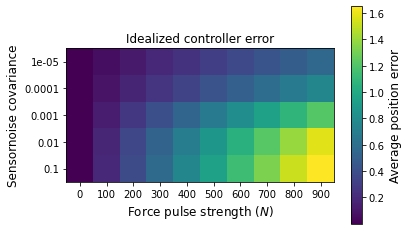

In [252]:
# Plot dynamical variables in seperate plots
def scientific(x, pos):
    # x:  tick value - ie. what you currently see in yticks
    # pos: a position - ie. the index of the tick (from 0 to 9 in this example)
    if x == 0:
        return 0
    else:
        return str(x) + "e4"

scientific_formatter = FuncFormatter(scientific)

fig = plt.figure()
ax = plt.axes()
#fig.set_figheight(12)
#fig.set_figwidth(6)
#fig.set_figheight(4)
#fig.set_figwidth(12)
legend_fontsize=12

#ax1 = plt.subplot2grid(shape=(3, 1), loc=(0, 0), colspan=1)
#ax2 = plt.subplot2grid(shape=(3, 1), loc=(1, 0), colspan=1)
#ax3 = plt.subplot2grid(shape=(3, 1), loc=(0, 1), rowspan=2)

# Run the 'real' dynamical system with previously defined A-matrix and x0:
#_fe = X_hat_fe

#OLD HEX VALUES
#EE0000
#008A00
#D100D1

# "of position (x$_{1}$ and x̂$_{1}$) and acceleration (x$_{2}$ and x̂$_{2}$)"
legend=[]
plt.imshow(ideal_avg_pos_error,vmax=1.65)
ax.set_xticks(range(len(n_pulse_strength)))
ax.set_xticklabels(n_pulse_strength)
#plt.ticklabel_format(style='scientific')
ax.set_yticks(range(len(n_sensornoise)))
ax.set_yticklabels(n_sensornoise)
#ax.xaxis.set_major_formatter(scientific_formatter)
ax.set_xlabel('Force pulse strength ($N$)',fontsize = 12)
ax.set_ylabel('Sensornoise covariance',fontsize = 12)

colorbar = plt.colorbar()
colorbar.ax.set_ylabel('Average position error', fontsize = 12)
# legend.append("x$^*_{"+str(1)+"}$")
# #ax1.plot(np.arange(0,Time+dt,dt),X_hat_fe[0],color='#0000FF')
# #legend.append("x̂$_{"+str(1)+"}$_FE")
# axs[0].plot(np.arange(0,Time+dt,dt),X_scn[0],color='#00B050')
# legend.append("x$_{"+str(1)+"}$")
# axs[0].plot(np.arange(0,Time+dt,dt),x_des[0],linestyle='dashed',c="#0070C0")
# legend.append("z$_{1}$")
# axs[0].legend(legend,fontsize=legend_fontsize,loc='right')

#axs[2].set_yticks([0,1,2,3,4,5,6,7,8,9])
plt.title('Idealized controller error')
plt.savefig('idealcontrolrange.svg', facecolor='white', transparent=False, dpi=300, bbox_inches='tight')
plt.savefig('idealcontrolrange.png', facecolor='white', transparent=False, dpi=300, bbox_inches='tight')
plt.show()

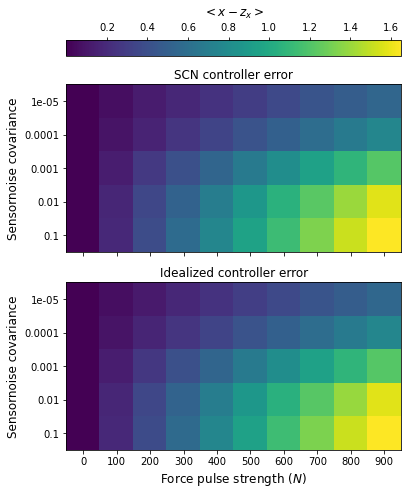

In [258]:
#Combined figure
#fig = plt.figure()
fig, axs = plt.subplots(2,1, sharex= True, gridspec_kw = {'hspace':0.1,'height_ratios':[1.3,1]})
fig.set_figheight(8)
fig.set_figwidth(6)
legend=[]
axs[0].imshow(scn_avg_pos_error,vmax=1.65)
axs[0].set_xticks(range(len(n_pulse_strength)))
axs[0].set_xticklabels(n_pulse_strength)
#plt.ticklabel_format(style='scientific')
axs[0].set_yticks(range(len(n_sensornoise)))
axs[0].set_yticklabels(n_sensornoise)
#ax.xaxis.set_major_formatter(scientific_formatter)
#axs[0].set_xlabel('Force pulse strength ($N$)',fontsize = 12)
axs[0].set_ylabel('Sensornoise covariance',fontsize = 12)
axs[0].set_title('SCN controller error')
legend=[]
im=axs[1].imshow(ideal_avg_pos_error,vmax=1.65)
axs[1].set_xticks(range(len(n_pulse_strength)))
axs[1].set_xticklabels(n_pulse_strength)
#plt.ticklabel_format(style='scientific')
axs[1].set_yticks(range(len(n_sensornoise)))
axs[1].set_yticklabels(n_sensornoise)
#ax.xaxis.set_major_formatter(scientific_formatter)
axs[1].set_xlabel('Force pulse strength ($N$)',fontsize = 12)
axs[1].set_ylabel('Sensornoise covariance',fontsize = 12)
axs[1].set_title('Idealized controller error')
#cax = fig.add_axes([-0.1, 0.1, 0.03, 0.8])
#colorbar.ax.yaxis.tick_left()
colorbar = plt.colorbar(im,ax=axs[0],location="top",orientation="horizontal",pad=0.12)
#colorbar.ax.set_ylabel('Average position error', fontsize = 12, loc="top")
#colorbar.ax.yaxis.set_label_position("top")
colorbar.ax.set_title("$<x-z_x>$",fontsize=12)

plt.savefig('controlrangeplot.svg', facecolor='white', transparent=False, dpi=300, bbox_inches='tight')
plt.savefig('controlrangeplot.png', facecolor='white', transparent=False, dpi=300, bbox_inches='tight')
plt.show()

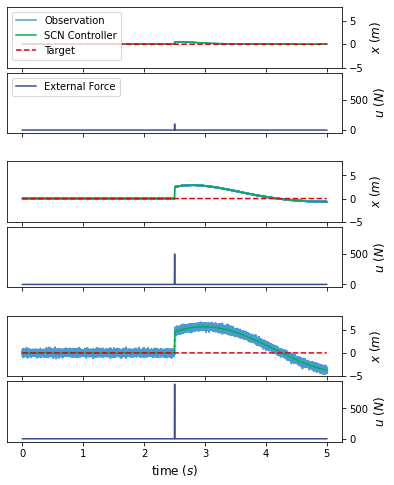

In [259]:
fig, axs = plt.subplots(8,1, sharex=True, squeeze=True, gridspec_kw = {'hspace':0.1,'height_ratios':[1,1,0.3,1,1,0.3,1,1]})
fig.set_figheight(8)
fig.set_figwidth(6)
legend_fontsize=10

axs[2].set_visible(False)
axs[5].set_visible(False)

legend=[]
# axs[0].plot(np.arange(0,Time+dt,dt),error_list[0][0][7][0],color='#E3000B',linewidth=3)
# legend.append("Idealized LQR")
axs[0].plot(np.arange(0,Time+dt,dt),error_list[0][1][10][0],color='#0070C0',alpha=0.7)
legend.append("Observation")
axs[0].plot(np.arange(0,Time+dt,dt),error_list[0][1][6][0],color='#00B050')
legend.append("SCN Controller")
axs[0].plot(np.arange(0,Time+dt,dt),error_list[0][1][9][0],linestyle='dashed',color='#E3000B')
legend.append("Target")
axs[0].legend(legend,fontsize=legend_fontsize,loc='upper left')
axs[0].set_ylabel('$x$ $(m)$',fontsize = 12)
axs[0].yaxis.tick_right()
axs[0].yaxis.set_label_position("right")
axs[0].yaxis.set_label_position("right")
axs[0].set_ylim(-5, 8)

legend=[]
# axs[1].plot(np.arange(0,Time+dt,dt),error_list[0][0][3][0],color='#E3000B',linewidth=3)
# #legend.append("Idealized LQR u")
# axs[1].plot(np.arange(0,Time+dt,dt),error_list[0][0][2][0],color='#00B050')
#legend.append("SCN Controller u")
axs[1].plot(np.arange(0,Time+dt,dt),error_list[0][1][8][0],color='#394b94')
legend.append("External Force")
axs[1].legend(legend,fontsize=legend_fontsize,loc='upper left')
axs[1].set_ylabel('$u$ $(N)$',fontsize = 12)
#axs[1].set_xlabel('time ($s$)',fontsize = 12)
axs[1].yaxis.tick_right()
axs[1].yaxis.set_label_position("right")
axs[1].set_ylim(-50, 950)


legend=[]
# axs[3].plot(np.arange(0,Time+dt,dt),error_list[2][4][7][0],color='#E3000B',linewidth=3)
# legend.append("Idealized LQR")
axs[3].plot(np.arange(0,Time+dt,dt),error_list[2][5][10][0],color='#0070C0',alpha=0.7)
legend.append("Observation")
axs[3].plot(np.arange(0,Time+dt,dt),error_list[2][5][6][0],color='#00B050')
legend.append("SCN Controller")
axs[3].plot(np.arange(0,Time+dt,dt),error_list[2][5][9][0],linestyle='dashed',color='#E3000B')
legend.append("Target")
axs[3].set_ylabel('$x$ $(m)$',fontsize = 12)
axs[3].yaxis.tick_right()
axs[3].yaxis.set_label_position("right")
axs[3].set_ylim(-5, 8)

legend=[]
# axs[4].plot(np.arange(0,Time+dt,dt),error_list[2][4][3][0],color='#E3000B',linewidth=3) 
# legend.append("Idealized LQR u")
# axs[4].plot(np.arange(0,Time+dt,dt),error_list[2][4][2][0],color='#00B050')
# legend.append("SCN Controller u")
axs[4].plot(np.arange(0,Time+dt,dt),error_list[2][5][8][0],color='#394b94')
legend.append("External force")
axs[4].set_ylabel('$u$ $(N)$',fontsize = 12)
#axs[4].set_xlabel('time ($s$)',fontsize = 12)
axs[4].yaxis.tick_right()
axs[4].yaxis.set_label_position("right")
axs[4].set_ylim(-50, 950)


legend=[]
# axs[6].plot(np.arange(0,Time+dt,dt),error_list[4][9][7][0],color='#E3000B',linewidth=3)
# legend.append("Idealized LQR")
axs[6].plot(np.arange(0,Time+dt,dt),error_list[4][9][10][0],color='#0070C0',alpha=0.7)
legend.append("Observation")
axs[6].plot(np.arange(0,Time+dt,dt),error_list[4][9][6][0],color='#00B050')
legend.append("SCN Controller")
axs[6].plot(np.arange(0,Time+dt,dt),error_list[4][9][9][0],linestyle='dashed',color='#E3000B')
legend.append("Target")
axs[6].set_ylabel('$x$ $(m)$',fontsize = 12)
axs[6].yaxis.tick_right()
axs[6].yaxis.set_label_position("right")
axs[6].set_ylim(-5, 8)

legend=[]
# axs[7].plot(np.arange(0,Time+dt,dt),error_list[4][9][3][0],color='#E3000B',linewidth=3) 
# legend.append("Idealized LQR u")
# axs[7].plot(np.arange(0,Time+dt,dt),error_list[4][9][2][0],color='#00B050')
# legend.append("SCN Controller u")
axs[7].plot(np.arange(0,Time+dt,dt),error_list[4][9][8][0],color='#394b94')
legend.append("External force")
axs[7].set_ylabel('$u$ $(N)$',fontsize = 12)
axs[7].set_xlabel('time ($s$)',fontsize = 12)
axs[7].yaxis.tick_right()
axs[7].yaxis.set_label_position("right")
axs[7].set_ylim(-50, 950)


# axins = axs[0].inset_axes([0.3, 0.8, 0.15, 0.4])
# range_plot_x,range_plot_y=18000,21000
# axins.plot(np.arange(0,Time+dt,dt)[range_plot_x:range_plot_y],error_list[0][0][6][0][range_plot_x:range_plot_y],color='#00B050',linewidth=3)
# axins.plot(np.arange(0,Time+dt,dt)[range_plot_x:range_plot_y],error_list[0][0][9][0][range_plot_x:range_plot_y],linestyle='dashed',color='#E3000B')
# axins.plot(np.arange(0,Time+dt,dt)[range_plot_x:range_plot_y],error_list[0][0][10][0][range_plot_x:range_plot_y],color='#0070C0',alpha=0.7)
# #x1, x2, y1, y2 = 0, 0.1, 0, 5
# #ax_in.set_xlim(x1, x2)
# #ax_in.set_ylim(y1, y2)
# axins.set_xticklabels([])
# axins.set_yticklabels([])
# axins.set_ylim(-0.01,0.01)

# axs[0].indicate_inset_zoom(axins, edgecolor="black")

# axins = axs[3].inset_axes([0.3, 0.8, 0.15, 0.4])
# range_plot_x,range_plot_y=18000,21000
# axins.plot(np.arange(0,Time+dt,dt)[range_plot_x:range_plot_y],error_list[2][4][6][0][range_plot_x:range_plot_y],color='#00B050',linewidth=3)
# axins.plot(np.arange(0,Time+dt,dt)[range_plot_x:range_plot_y],error_list[2][4][9][0][range_plot_x:range_plot_y],linestyle='dashed',color='#E3000B')
# axins.plot(np.arange(0,Time+dt,dt)[range_plot_x:range_plot_y],error_list[2][4][10][0][range_plot_x:range_plot_y],color='#0070C0',alpha=0.7)
# #x1, x2, y1, y2 = 0, 0.1, 0, 5
# #ax_in.set_xlim(x1, x2)
# #ax_in.set_ylim(y1, y2)
# axins.set_xticklabels([])
# axins.set_yticklabels([])
# axins.set_ylim(-0.01,0.01)

# axs[3].indicate_inset_zoom(axins, edgecolor="black")

# axins = axs[6].inset_axes([0.3, 0.8, 0.15, 0.4])
# range_plot_x,range_plot_y=18000,21000
# axins.plot(np.arange(0,Time+dt,dt)[range_plot_x:range_plot_y],error_list[4][9][6][0][range_plot_x:range_plot_y],color='#00B050',linewidth=3)
# axins.plot(np.arange(0,Time+dt,dt)[range_plot_x:range_plot_y],error_list[4][9][9][0][range_plot_x:range_plot_y],linestyle='dashed',color='#E3000B')
# axins.plot(np.arange(0,Time+dt,dt)[range_plot_x:range_plot_y],error_list[4][9][10][0][range_plot_x:range_plot_y],color='#0070C0',alpha=0.7)
# #x1, x2, y1, y2 = 0, 0.1, 0, 5
# #ax_in.set_xlim(x1, x2)
# #ax_in.set_ylim(y1, y2)
# axins.set_xticklabels([])
# axins.set_yticklabels([])
# axins.set_ylim(-0.01,0.01)

# axs[6].indicate_inset_zoom(axins, edgecolor="black")


plt.savefig('controlrangeplotplots.svg', facecolor='white', transparent=False, dpi=300, bbox_inches='tight')
plt.savefig('controlrangeplotplots.png', facecolor='white', transparent=False, dpi=300, bbox_inches='tight')
plt.show()